In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib


In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

# Check shapes
print("Shape of X:", X.shape)  # (70000, 784)
print("Shape of y:", y.shape)  # (70000,)


Shape of X: (70000, 784)
Shape of y: (70000,)


In [3]:
y = y.astype(np.uint8)  # Convert string labels to integer


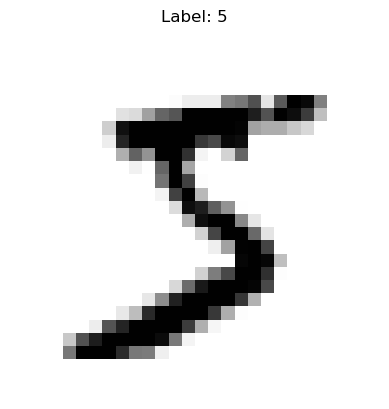

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title(f"Label: {y[0]}")
plt.show()


In [5]:
print([y[i] for i in range(10)])


[np.uint8(5), np.uint8(0), np.uint8(4), np.uint8(1), np.uint8(9), np.uint8(2), np.uint8(1), np.uint8(3), np.uint8(1), np.uint8(4)]


In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [9]:
#Checking if the given didgit is 5 or not 5
print(sgd_clf.predict([some_digit,X[2]]))


[ True False]


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Create Stratified K-Fold with 3 splits
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # create a fresh copy of the classifier

    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # Train the clone on the fold
    clone_clf.fit(X_train_folds, y_train_folds)

    # Predict on the test fold
    y_pred = clone_clf.predict(X_test_fold)

    # Calculate accuracy
    n_correct = sum(y_pred == y_test_fold)
    print("Fold Accuracy:", n_correct / len(y_pred))


Fold Accuracy: 0.9669
Fold Accuracy: 0.91625
Fold Accuracy: 0.96785


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
    

array([0.91125, 0.90855, 0.90915])

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [18]:
threshold = 0
y_some_digit_prediction = (y_scores>threshold)
y_some_digit_prediction

array([ True])

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [20]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5, y_scores)

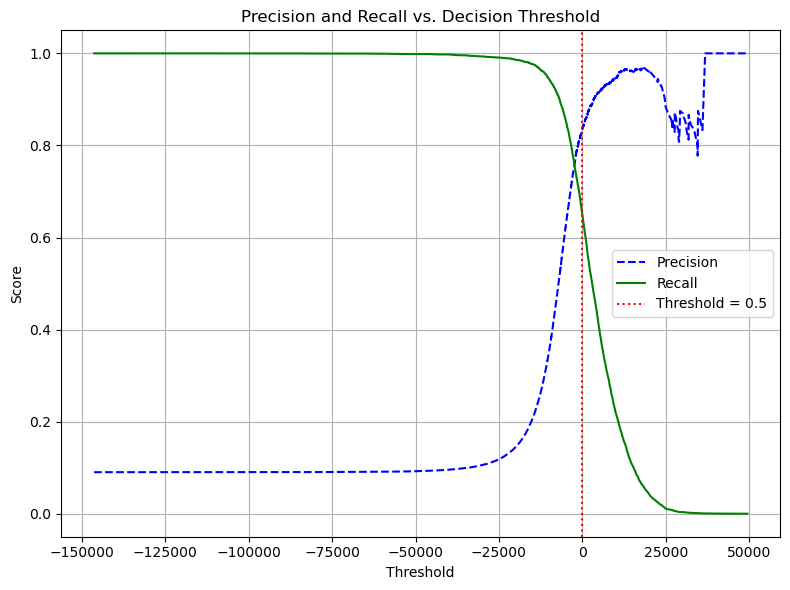

In [21]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold_line=True):
    plt.figure(figsize=(8, 6))
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    if threshold_line:
        plt.axvline(x=0.5, color="r", linestyle=":", label="Threshold = 0.5")

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs. Decision Threshold")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


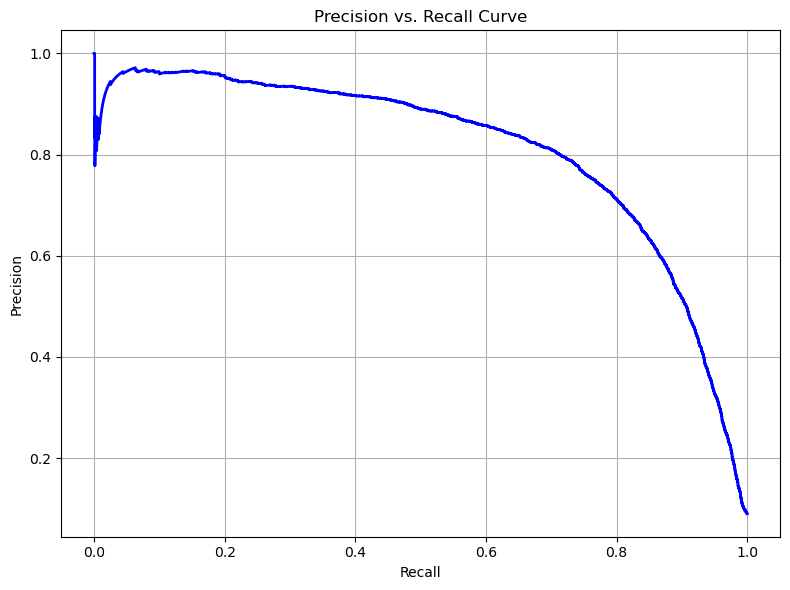

In [22]:
import matplotlib.pyplot as plt

def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision vs. Recall Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_precision_vs_recall(precisions, recalls)


In [23]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [24]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [25]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

<function matplotlib.pyplot.show(close=None, block=None)>

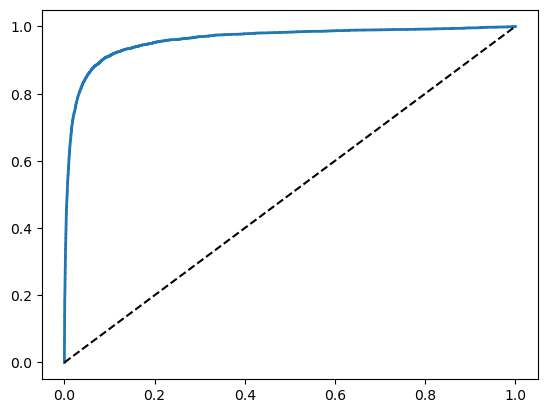

In [26]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)
def plot_roc_curve(fpr,tpr,label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

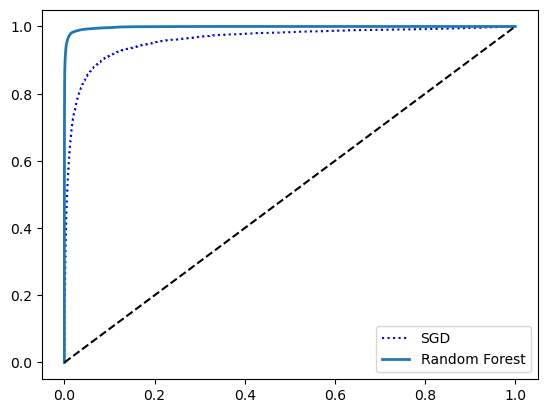

In [28]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method = "predict_proba")


y_scores_forest = y_probas_forest[:, 1]
# score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [30]:
cross_val_score(forest_clf, X_train, y_train_5, cv=2, scoring="accuracy")

array([0.98633333, 0.98556667])

In [31]:
cross_val_score(forest_clf, X_train, y_train_5, cv=2,scoring= "recall")

array([0.85724825, 0.84649446])

In [32]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [33]:
o =2
digi = X_test[o]
ans = y_test[o]
print(svm_clf.predict([digi]))
print(ans)

[1]
1


In [35]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print("Max score class index:", np.argmax(some_digit_scores))
print("Predicted class:", svm_clf.classes_[np.argmax(some_digit_scores)])


[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
Max score class index: 5
Predicted class: 5


In [36]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [37]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [38]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [40]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

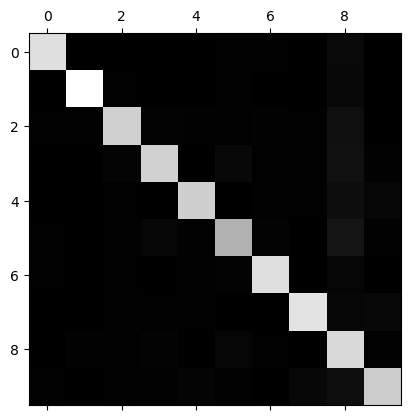

In [41]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

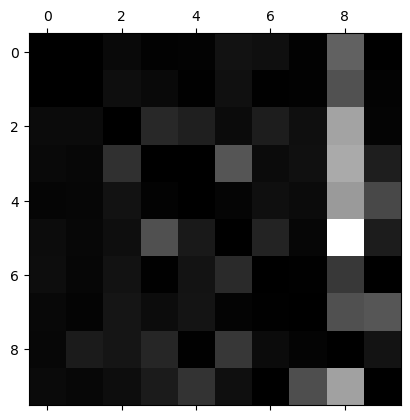

In [42]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

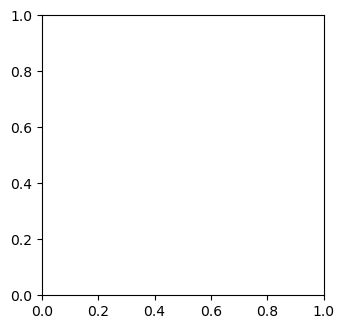

In [43]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [44]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [45]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'knn_clf' is not defined